In [1]:
"""
numpy-1.26.4
scikit-learn-1.5.2
tensorflow-2.18.0
timm-1.0.11
huggingface_hub-0.26.2

@misc{szegedy2016inceptionv4,
      title={Inception-v4, Inception-ResNet and the Impact of Residual Connections on Learning}, 
      author={Christian Szegedy and Sergey Ioffe and Vincent Vanhoucke and Alex Alemi},
      year={2016},
      eprint={1602.07261},
      archivePrefix={arXiv},
      primaryClass={cs.CV}
}

"""
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from sklearn.datasets import fetch_lfw_people
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from sklearn.model_selection import train_test_split
from torchmetrics.classification import Accuracy
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy.ndimage import rotate
from skimage.exposure import rescale_intensity
from skimage import exposure
from torchvision.transforms import functional as TF

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("GPU not available, using CPU")

torch.cuda.empty_cache()

GPU is available: NVIDIA GeForce RTX 4090


Inplementation of InceptionV3+Qlearning+gamma code of LFW

In [3]:
# the original paper choose 250 images from LFW in some unknown ways
# # Function to filter and sample dataset
# def filter_lfw_people(min_faces_per_person, samples_per_class):
#     lfw_people = fetch_lfw_people(min_faces_per_person=min_faces_per_person, resize=1.0)
#     X = lfw_people.images
#     y = lfw_people.target
#     target_names = lfw_people.target_names
#     k = len(np.unique(y))

#     filtered_X = []
#     filtered_y = []
#     for class_label in range(k):
#         class_indices = np.where(y == class_label)[0]
#         selected_indices = np.random.choice(class_indices, size=min(samples_per_class, len(class_indices)), replace=False)
#         filtered_X.extend(X[selected_indices])
#         filtered_y.extend(y[selected_indices])

#     filtered_X = np.array(filtered_X)
#     filtered_y = np.array(filtered_y)
#     return filtered_X, filtered_y, target_names

# # Filter dataset
# X, y, target_names = filter_lfw_people(min_faces_per_person=30, samples_per_class=6)
# k = len(np.unique(y))
# print(f"Filtered dataset shape: {X.shape}, Number of classes: {k}")
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=1.0)  # Load full size image
X = lfw_people.images
y = lfw_people.target
k = len(np.unique(y))
target_names = lfw_people.target_names

In [4]:
# Dataset with on-the-fly augmentation
class AugmentedDataset(Dataset):
    def __init__(self, X, y, gamma_values, rotations):
        self.X = X
        self.y = y
        self.gamma_values = gamma_values
        self.rotations = rotations

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = self.X[idx]
        label = self.y[idx]

        # Random rotation
        angle = int(np.random.choice(self.rotations))  # Ensure angle is a Python int
        img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0)  # Add channel dimension
        img_rotated = TF.rotate(img_tensor, angle, interpolation=TF.InterpolationMode.BILINEAR).clamp(0, 1)

        # Random gamma correction
        gamma = np.random.choice(self.gamma_values)
        img_augmented = img_rotated ** gamma

        # Convert to RGB and preprocess
        img_rgb = torch.cat([img_augmented] * 3, dim=0)  # Convert grayscale to RGB
        img_resized = TF.resize(img_rgb, [299, 299])

        return img_resized, label

In [5]:
# Augmentation parameters
gamma_values = [0.05, 0.1, 0.2, 0.4, 0.6, 1, 1.5, 1.8, 2, 3, 4, 6]
rotations = list(range(0, 360, 15))

In [6]:
# Create dataset and DataLoader
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2, random_state=42)
train_dataset = AugmentedDataset(train_X, train_y, gamma_values, rotations)
val_dataset = AugmentedDataset(val_X, val_y, gamma_values, rotations)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [7]:
# Q-learning parameters 
gamma_discount = 0.9
immediate_reward = 0.3
# The original converge points in paper
total_iterations = 16000
loss_threshold = 1.76

# Define combined loss function
class QLearningLoss(nn.Module):
    def __init__(self, gamma_discount):
        super(QLearningLoss, self).__init__()
        self.gamma_discount = gamma_discount

    def forward(self, q_current, q_next, reward, target_action):
        q_target = reward + self.gamma_discount * torch.max(q_next, dim=1)[0]
        return (q_current.gather(1, target_action.unsqueeze(1)) - q_target.unsqueeze(1)).pow(2).mean()

# Define combined model
class InceptionV3_Transfer(nn.Module):
    def __init__(self, base_model, num_classes):
        super(InceptionV3_Transfer, self).__init__()
        self.base_model = base_model
        self.fc = nn.Linear(base_model.num_features, num_classes)  # Fully connected layer for classification

    def forward(self, x):
        features = self.base_model(x)
        logits = self.fc(features)
        return logits, features  # Logits for classification, features for Q-values

In [8]:
# Initialize model and optimizer
base_model = timm.create_model('inception_v3', pretrained=True, num_classes=0)
model = InceptionV3_Transfer(base_model, k).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion_ce = nn.CrossEntropyLoss()
criterion_q = QLearningLoss(gamma_discount)


In [9]:
epochs = 10  # Number of epochs
iteration = 0  # Total iteration count
max_iterations = total_iterations  # Maximum iterations
loss_threshold = 1.76  # Early stopping loss threshold but seems not work for unknown loss function in original paper

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    print(f"Epoch {epoch + 1}/{epochs}")
    for i, (inputs, labels) in enumerate(train_loader):
        if iteration >= max_iterations:
            print("Reached maximum iterations. Stopping training.")
            break

        # Move data to device
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        # Forward pass
        logits, features = model(inputs)
        q_values = features  # Use features as Q-values

        # Calculate Q-learning loss
        q_next = q_values.detach()  # Detach to prevent gradients
        q_loss = criterion_q(q_values, q_next, immediate_reward, labels)

        # Calculate cross-entropy loss
        ce_loss = criterion_ce(logits, labels)

        # Combine losses
        loss = ce_loss + q_loss

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(logits, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        iteration += 1  # Increment iteration count

    avg_loss = train_loss / len(train_loader)
    accuracy = correct / total * 100
    print(f"Iteration: {iteration}, Combined Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

    # # Early stopping
    # if avg_loss < loss_threshold and iteration >= 330:  # Ensure enough iterations for stability
    #     print(f"Stopping early as loss dropped below {loss_threshold}.")
    #     break

print("Training complete!")


Epoch 1/10
Iteration: 33, Combined Loss: 3.0479, Accuracy: 42.52%
Epoch 2/10
Iteration: 66, Combined Loss: 1.8071, Accuracy: 60.87%
Epoch 3/10
Iteration: 99, Combined Loss: 1.4510, Accuracy: 66.60%
Epoch 4/10
Iteration: 132, Combined Loss: 1.1471, Accuracy: 72.52%
Epoch 5/10
Iteration: 165, Combined Loss: 1.0800, Accuracy: 74.76%
Epoch 6/10
Iteration: 198, Combined Loss: 0.9721, Accuracy: 77.77%
Epoch 7/10
Iteration: 231, Combined Loss: 0.7730, Accuracy: 82.62%
Epoch 8/10
Iteration: 264, Combined Loss: 0.6386, Accuracy: 84.85%
Epoch 9/10
Iteration: 297, Combined Loss: 0.7679, Accuracy: 82.91%
Epoch 10/10
Iteration: 330, Combined Loss: 0.6444, Accuracy: 85.24%
Training complete!


In [10]:
# Validation and Gamma Performance
gamma_values = [0.05, 0.1, 0.2, 0.4, 0.6, 1, 1.5, 1.8, 2, 3, 4, 6]
gamma_acc = {}

model.eval()
for gamma in gamma_values:
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            # Apply gamma correction
            inputs = torch.tensor(np.array([img.cpu().numpy() ** gamma for img in inputs]), device=device)
            labels = labels.to(device)  # Move labels to the same device as inputs
            logits, _ = model(inputs)  # Unpack logits and features
            _, predicted = torch.max(logits, 1)  # Use logits for predictions
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)
    gamma_acc[gamma] = val_correct / val_total * 100

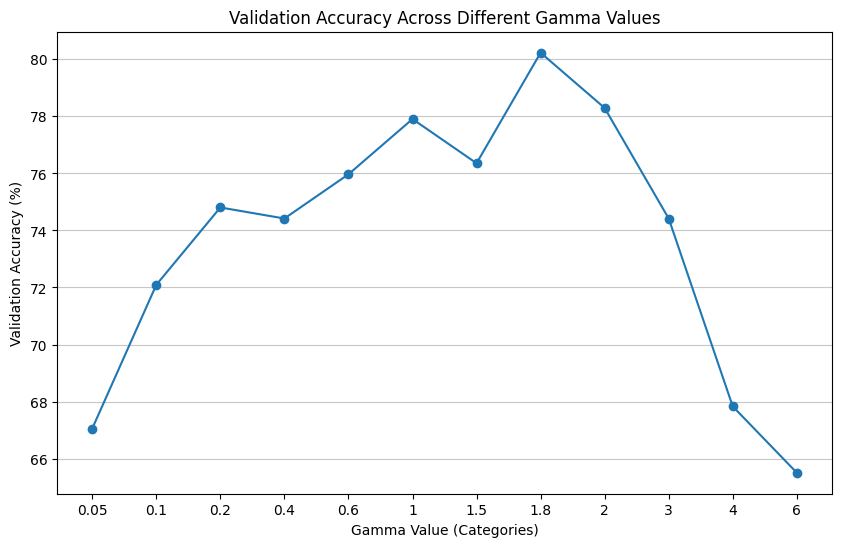

In [11]:
# Treat gamma_values as evenly spaced categories
gamma_labels = [str(gamma) for gamma in gamma_values]
x_positions = range(len(gamma_labels))  # Evenly spaced positions for the labels

# Plot performance
plt.figure(figsize=(10, 6))
plt.plot(x_positions, list(gamma_acc.values()), marker='o')  # Use positions for x-axis
plt.xticks(x_positions, gamma_labels)  # Set the gamma values as labels
plt.xlabel('Gamma Value (Categories)')
plt.ylabel('Validation Accuracy (%)')
plt.title('Validation Accuracy Across Different Gamma Values')
plt.grid(axis='y', linestyle='-', alpha=0.7)
plt.show()